# Word2Vec NN

In [1]:
FILE_NAME = "word2vec"
TITLE = "Word2Vec_CNN"

In [2]:
from utils.load_data import get_data, load_parquet_data

size = 's'

X_train, X_test, y_train, y_test = get_data(size)
print([X_train.shape, X_test.shape, y_train.shape, y_test.shape])


[(128000,), (32000,), (128000,), (32000,)]


## Fit Model

In [3]:
from gensim.models import Word2Vec

model_word2vec = Word2Vec.load("./output/word2vec.model")


In [4]:
import numpy as np
import polars as pl
import tensorflow as tf
from keras.layers import GRU, Conv1D, Dense, Embedding, MaxPooling1D
from keras.models import Sequential

# from utils.word2vec import get_embedding_layer, GensimEmbedding

2023-03-23 02:28:55.000312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 02:28:55.591051: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-23 02:28:55.591118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-23 02:28:55.591124: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [5]:
def get_embedding_layer(model):
    embedding_matrix = np.zeros((len(model.wv.index_to_key) + 1, model.vector_size))
    word2idx = {}

    vocab_list = [(word, model.wv[word]) for word in model.wv.index_to_key]
    for i, vocab in enumerate(vocab_list):
        word, vec = vocab
        embedding_matrix[i + 1] = vec
        word2idx[word] = i + 1

    embedding_layer = Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=False,
    )

    return embedding_layer


In [6]:
from keras.utils import pad_sequences

def process(texts):
    PADDING_LENGTH = 128
    supported_words = set(model_word2vec.wv.index_to_key)

    text_index = [[model_word2vec.wv.key_to_index[word] if word in supported_words else 0 for word in sentence] for sentence in texts]
    text_index = pad_sequences(text_index, maxlen=PADDING_LENGTH)
    return np.array(text_index)


In [7]:
import time
id = time.strftime('%H%M%S')

cnn = Sequential(name=f"{TITLE}_{id}")
cnn.add(get_embedding_layer(model_word2vec))
cnn.add(Conv1D(128, 3, activation='relu'))
cnn.add(MaxPooling1D(3))
cnn.add(Conv1D(128, 3, activation='relu'))
cnn.add(MaxPooling1D(3))
cnn.add(Conv1D(32, 3, activation='relu'))
cnn.add(MaxPooling1D(3))
cnn.add(Dense(16, activation="relu"))
cnn.add(Dense(1, activation="sigmoid"))
cnn.add(Dense(1, activation="sigmoid"))

# cnn.build((1,))
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn.summary()


2023-03-23 02:28:56.191779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-23 02:28:56.212571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-23 02:28:56.212859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-23 02:28:56.213258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Model: "Word2Vec_CNN_022856"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         12709500  
                                                                 
 conv1d (Conv1D)             (None, None, 128)         115328    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)  

In [8]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
ckpt = tf.keras.callbacks.ModelCheckpoint(f'./output/model_nn/{FILE_NAME}_{id}_{size}_model.h5', monitor='val_loss', save_best_only=True, mode='auto')
board = tf.keras.callbacks.TensorBoard(log_dir=f"./output/model_nn/logs/{FILE_NAME}_{id}/", histogram_freq=1, embeddings_freq=1)

callbacks = [earlyStopping, ckpt, board]

In [9]:
X_train_processed = process(X_train)
X_test_processed = process(X_test)
y_train_processed = np.where(y_train == 'true', 1, 0).astype('float32').reshape((-1,1))
y_test_processed = np.where(y_test == 'true', 1, 0).astype('float32').reshape((-1,1))

In [10]:
result = cnn.fit(x=X_train_processed, y=y_train_processed, batch_size=500, epochs=10000, validation_split=0.4, callbacks=callbacks)


Epoch 1/10000


2023-03-23 02:29:01.201214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-03-23 02:29:02.730571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-23 02:29:02.735308: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x309cabb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-23 02:29:02.735339: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-23 02:29:02.739412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-23 02:29:02.872255: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the 

154/154 [==============================] - 9s 25ms/step - loss: 0.6909 - accuracy: 0.5365 - val_loss: 0.6901 - val_accuracy: 0.5414
Epoch 2/10000
154/154 [==============================] - 3s 22ms/step - loss: 0.6826 - accuracy: 0.5690 - val_loss: 0.6725 - val_accuracy: 0.5996
Epoch 3/10000
154/154 [==============================] - 4s 26ms/step - loss: 0.6630 - accuracy: 0.6170 - val_loss: 0.6663 - val_accuracy: 0.6026
Epoch 4/10000
154/154 [==============================] - 4s 25ms/step - loss: 0.6506 - accuracy: 0.6335 - val_loss: 0.6467 - val_accuracy: 0.6355
Epoch 5/10000
154/154 [==============================] - 4s 24ms/step - loss: 0.6379 - accuracy: 0.6498 - val_loss: 0.6375 - val_accuracy: 0.6455
Epoch 6/10000
154/154 [==============================] - 4s 25ms/step - loss: 0.6271 - accuracy: 0.6606 - val_loss: 0.6336 - val_accuracy: 0.6482
Epoch 7/10000
154/154 [==============================] - 4s 26ms/step - loss: 0.6160 - accuracy: 0.6714 - val_loss: 0.6282 - val_accuracy:

In [11]:
results = cnn.evaluate(X_test_processed, y_test_processed, batch_size=3000, return_dict=True)
print("Testing", results)

11/11 [==============================] - 0s 31ms/step - loss: 0.6033 - accuracy: 0.6828
Testing {'loss': 0.6033486127853394, 'accuracy': 0.6827917695045471}


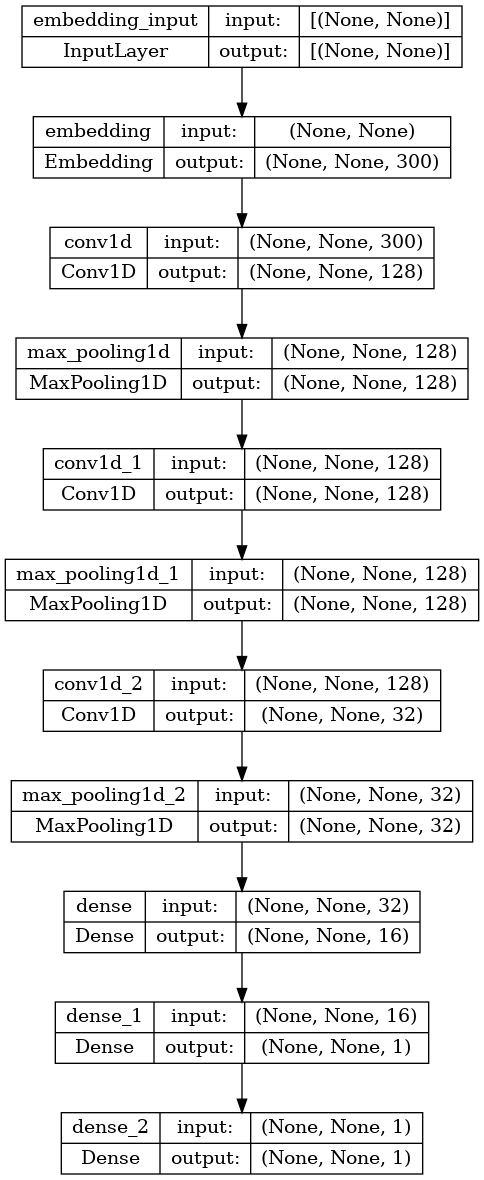

In [12]:
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)

from keras.utils import plot_model

plot_model(cnn, f"./output/model_nn/{FILE_NAME}_{id}_{size}_cnn_model.png", show_shapes=True)

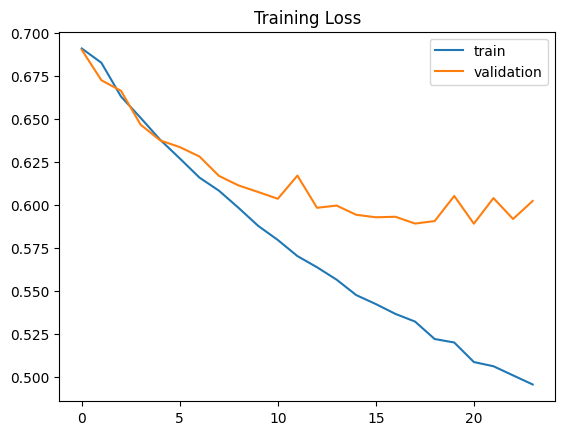

In [13]:
# Plot loss graph
import matplotlib.pyplot as plt

plt.title('Training Loss')
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')

plt.savefig(f'./output/model_nn/{FILE_NAME}_{id}_{size}_cnn_model_loss.png')

In [14]:
new_model = tf.keras.models.load_model(f'./output/model_nn/{FILE_NAME}_{id}_{size}_model.h5')

In [15]:
def predict(text):
    text_processed = process([text])
    return new_model.predict(text_processed)

In [16]:
predict("Wow iot is the best requirement")

1/1 [==============================] - 0s 209ms/step


array([[[0.44193852],
        [0.44193852],
        [0.7572081 ]]], dtype=float32)